In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score



import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("Using CUDA (GPU)")

    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS (macOS)")
    device = torch.device("mps")
else:
    print("Using CPU (Default)")
    device = torch.device("cpu")

Using CUDA (GPU)


In [3]:
full_dataset = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

print("Duplicate rows in full_dataset:", full_dataset.duplicated().sum())
#check difference between the two datasets with duplicate rows and without

full_dataset = full_dataset.drop_duplicates()

print("Duplicate rows in full_dataset:", full_dataset.duplicated().sum())


print("full_dataset shape:", full_dataset.shape)
#check for null values

print("Null values in full_dataset:", full_dataset.isnull().sum().sum())
#no NANs cool

full_dataset.info() # all columns are float cool



Duplicate rows in full_dataset: 23899
Duplicate rows in full_dataset: 0
full_dataset shape: (229781, 22)
Null values in full_dataset: 0
<class 'pandas.core.frame.DataFrame'>
Index: 229781 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          229781 non-null  float64
 1   HighBP                229781 non-null  float64
 2   HighChol              229781 non-null  float64
 3   CholCheck             229781 non-null  float64
 4   BMI                   229781 non-null  float64
 5   Smoker                229781 non-null  float64
 6   Stroke                229781 non-null  float64
 7   HeartDiseaseorAttack  229781 non-null  float64
 8   PhysActivity          229781 non-null  float64
 9   Fruits                229781 non-null  float64
 10  Veggies               229781 non-null  float64
 11  HvyAlcoholConsump     229781 non-null  float64
 12  AnyHealthcare         229

<Figure size 1200x1000 with 0 Axes>

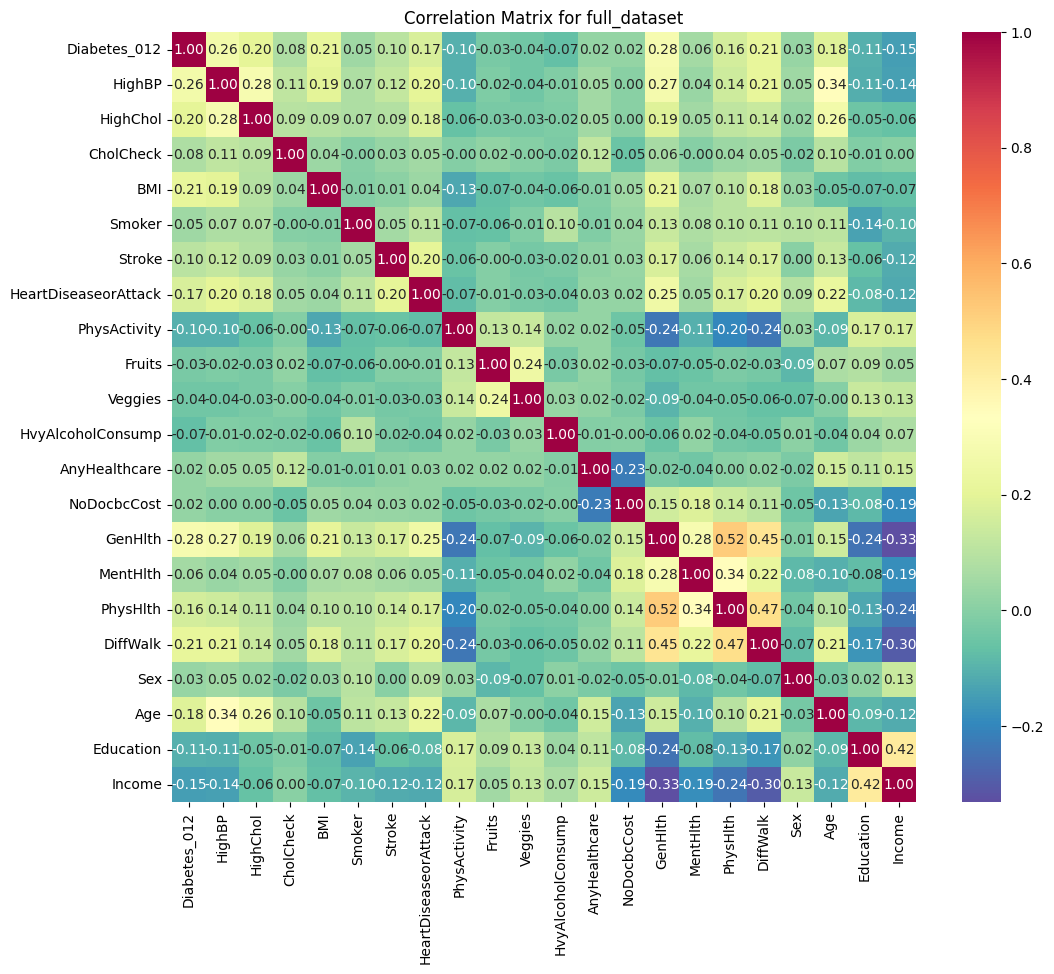

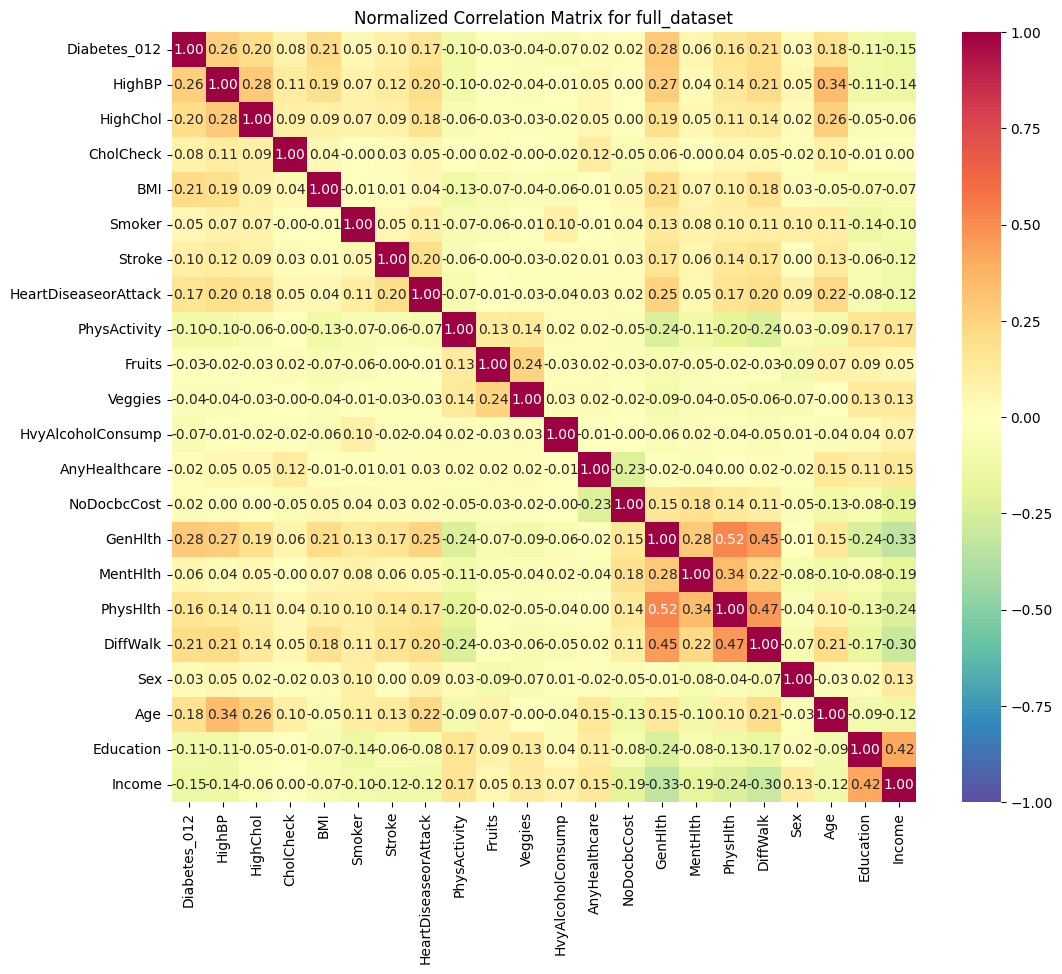

In [4]:
full_corr_matrix = full_dataset.corr()
plt.figure(figsize=(12, 10))


plt.figure(figsize=(12, 10))
sns.heatmap(full_corr_matrix, annot=True, fmt=".2f", cmap="Spectral_r")
plt.title("Correlation Matrix for full_dataset")
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(full_corr_matrix, annot=True, fmt=".2f", cmap="Spectral_r", vmin=-1, vmax=1)
plt.title("Normalized Correlation Matrix for full_dataset")
plt.show()

In [5]:
crosstab_result = pd.crosstab(full_dataset['HighBP'],full_dataset['Diabetes_012'])
print(crosstab_result)
print((full_dataset.groupby('Diabetes_012')['HighBP'].value_counts())/full_dataset.groupby('Diabetes_012')['HighBP'].count()*100 ,"\n")



crosstab_result = pd.crosstab(full_dataset['HighChol'],full_dataset['Diabetes_012'])
print(crosstab_result,"\n")
print((full_dataset.groupby('Diabetes_012')['HighChol'].value_counts())/full_dataset.groupby('Diabetes_012')['HighChol'].count()*100 ,"\n")



crosstab_result = pd.crosstab(full_dataset['HeartDiseaseorAttack'],full_dataset['Diabetes_012'])
print(crosstab_result,"\n")
print((full_dataset.groupby('Diabetes_012')['HeartDiseaseorAttack'].value_counts())/full_dataset.groupby('Diabetes_012')['HeartDiseaseorAttack'].count()*100 ,"\n")


crosstab_result = pd.crosstab(full_dataset['PhysActivity'],full_dataset['Diabetes_012'])
print(crosstab_result),"\n"
print((full_dataset.groupby('Diabetes_012')['PhysActivity'].value_counts())/full_dataset.groupby('Diabetes_012')['PhysActivity'].count()*100 ,"\n")


Diabetes_012     0.0   1.0    2.0
HighBP                           
0.0           114950  1717   8692
1.0            75105  2912  26405
Diabetes_012  HighBP
0.0           0.0       60.482492
              1.0       39.517508
1.0           1.0       62.907755
              0.0       37.092245
2.0           1.0       75.234351
              0.0       24.765649
dtype: float64 

Diabetes_012     0.0   1.0    2.0
HighChol                         
0.0           114917  1755  11601
1.0            75138  2874  23496 

Diabetes_012  HighChol
0.0           0.0         60.465129
              1.0         39.534871
1.0           1.0         62.086844
              0.0         37.913156
2.0           1.0         66.945893
              0.0         33.054107
dtype: float64 

Diabetes_012             0.0   1.0    2.0
HeartDiseaseorAttack                     
0.0                   174858  3965  27241
1.0                    15197   664   7856 

Diabetes_012  HeartDiseaseorAttack
0.0           0.0      

In [6]:
from imblearn.over_sampling import SMOTE

# Separate features and target variable
X = full_dataset.drop(columns=['Diabetes_012'])
y = full_dataset['Diabetes_012']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled features and target into a new DataFrame
resampled_dataset = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Diabetes_012'])], axis=1)

print("Original dataset shape:", full_dataset['Diabetes_012'].value_counts())
print("Resampled dataset shape:", y_resampled.value_counts())

Original dataset shape: Diabetes_012
0.0    190055
2.0     35097
1.0      4629
Name: count, dtype: int64
Resampled dataset shape: Diabetes_012
0.0    190055
2.0    190055
1.0    190055
Name: count, dtype: int64


In [7]:
# Initialize the multinomial logistic regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Random split of the resampled dataset
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Split that maintains the same proportions as the original dataset
X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Split on the original dataset
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the resampled dataset
log_reg.fit(X_train_random, y_train_random)

# Predict on the random test set
y_pred = log_reg.predict(X_test_random)

# Evaluate the model
accuracy = accuracy_score(y_test_random, y_pred)
print("Accuracy of the multinomial logistic regression model:", accuracy)
print("Accuracy of the multinomial logistic regression model on the original dataset:", accuracy_score(y_test_original, log_reg.predict(X_test_original)))
print("Accuracy of the multinomial logistic regression model on the stratified dataset:", accuracy_score(y_test_stratified, log_reg.predict(X_test_stratified)))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_random, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# Fit the model on the stratified dataset
log_reg.fit(X_train_stratified, y_train_stratified)
y_pred = log_reg.predict(X_test_stratified)

# Evaluate the model
accuracy = accuracy_score(y_test_stratified, y_pred)
print("Accuracy of the multinomial logistic regression model:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_random, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


#fit the model on the original dataset
log_reg.fit(X_train_original, y_train_original)
y_pred = log_reg.predict(X_test_original)
# Evaluate the model
accuracy = accuracy_score(y_test_original, y_pred)
print("Accuracy of the multinomial logistic regression model:", accuracy)
# Confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



Accuracy of the multinomial logistic regression model: 0.5255583909920812
Accuracy of the multinomial logistic regression model on the original dataset: 0.6254977478947712
Accuracy of the multinomial logistic regression model on the stratified dataset: 0.525523313426815
Confusion Matrix:
[[24176  6704  6903]
 [10387 12626 15245]
 [ 6227  8636 23129]]
Accuracy of the multinomial logistic regression model: 0.5254706970789158
Confusion Matrix:
[[13548  9499 14736]
 [13755  9499 15004]
 [13574  9393 15025]]
Accuracy of the multinomial logistic regression model: 0.8339317187805992
Confusion Matrix:
[[37161     0   955]
 [  831     0    75]
 [ 5771     0  1164]]


In [ ]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.combine import SMOTETomek

# Initialize undersampling algorithms
random_under_sampler = RandomUnderSampler(random_state=42)
tomek_links = TomekLinks()
near_miss = NearMiss()

# Separate features and target variable
X = full_dataset.drop(columns=['Diabetes_012'])
y = full_dataset['Diabetes_012']

# Apply Random Under Sampling
X_rus, y_rus = random_under_sampler.fit_resample(X, y)
print("Random Under Sampling:")
print("Resampled dataset shape:", y_rus.value_counts())

# Apply Tomek Links
X_tomek, y_tomek = tomek_links.fit_resample(X, y)
print("\nTomek Links:")
print("Resampled dataset shape:", y_tomek.value_counts())

# Apply Near Miss
X_nm, y_nm = near_miss.fit_resample(X, y)
print("\nNear Miss:")
print("Resampled dataset shape:", y_nm.value_counts())

Random Under Sampling:
Resampled dataset shape: Diabetes_012
0.0    4629
1.0    4629
2.0    4629
Name: count, dtype: int64

Tomek Links:
Resampled dataset shape: Diabetes_012
0.0    181161
2.0     26946
1.0      4629
Name: count, dtype: int64

Near Miss:
Resampled dataset shape: Diabetes_012
0.0    4629
1.0    4629
2.0    4629
Name: count, dtype: int64


Accuracy (Random Split): 0.8277
Precision: 0.7711
Recall: 0.8277
F1 Score: 0.7552
classification report
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91     37993
         1.0       0.00      0.00      0.00       957
         2.0       0.56      0.02      0.04      7006

    accuracy                           0.83     45956
   macro avg       0.46      0.34      0.32     45956
weighted avg       0.77      0.83      0.76     45956



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

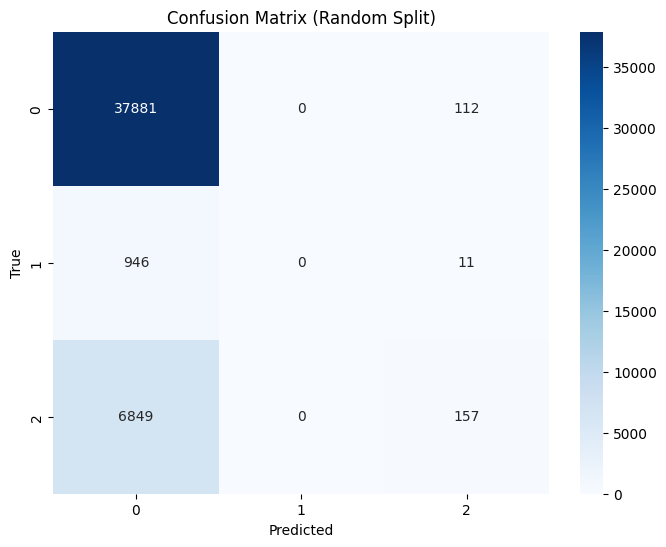

In [11]:
import cudf
import cupy as cp
from cuml.svm import SVC
from cuml.metrics import accuracy_score as cuml_accuracy_score
from cuml.model_selection import train_test_split as cuml_train_test_split
#convert pandas dataframe to cudf dataframe
cudf_full = cudf.DataFrame.from_pandas(full_dataset)
# Separate features and target variable
X_cudf = cudf_full.drop(columns=['Diabetes_012'])
y_cudf = cudf_full['Diabetes_012']

#svm model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovo')
# Random split of the resampled dataset
X_train_random_cudf, X_test_random_cudf, y_train_random_cudf, y_test_random_cudf = cuml_train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)
svm_model.fit(X_train_random_cudf, y_train_random_cudf)
# Make predictions on the test set
y_pred_random_cudf = svm_model.predict(X_test_random_cudf)
# Calculate accuracy
accuracy_random_cudf = cuml_accuracy_score(y_test_random_cudf, y_pred_random_cudf)
print(f"Accuracy (Random Split): {accuracy_random_cudf:.4f}")
#precision
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision in pandas
precision = precision_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
recall = recall_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
f1 = f1_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#confusion matrix
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns
import matplotlib.pyplot as plt
print("classification report")
print(classification_report(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy()))
# Convert cudf DataFrame to pandas DataFrame for confusion matrix
y_test_random_cudf = y_test_random_cudf.to_pandas()
y_pred_random_cudf = y_pred_random_cudf.to_pandas()
conf_matrix_random_cudf = confusion_matrix(y_test_random_cudf, y_pred_random_cudf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_cudf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Split)')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


Accuracy (Random Split): 0.5129
Precision: 0.5356
Recall: 0.5129
F1 Score: 0.4426


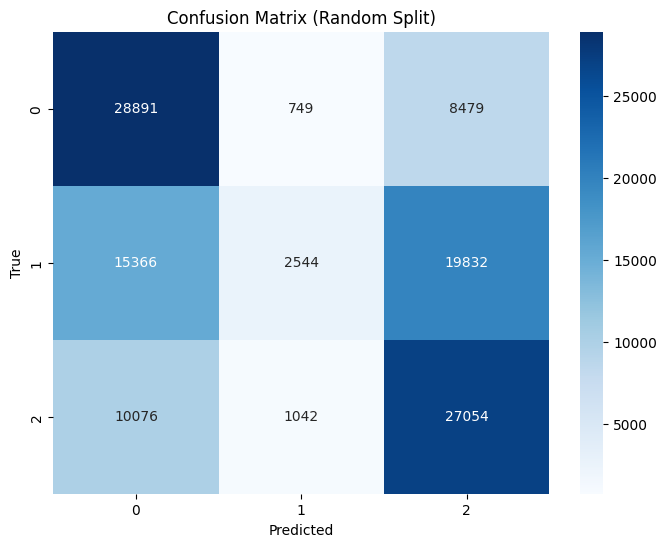

In [10]:
import cudf
import cupy as cp
from cuml.svm import SVC
from cuml.metrics import accuracy_score as cuml_accuracy_score
from cuml.model_selection import train_test_split as cuml_train_test_split
#convert pandas dataframe to cudf dataframe
cudf_smote = cudf.DataFrame.from_pandas(resampled_dataset)
# Separate features and target variable
X_cudf = cudf_smote.drop(columns=['Diabetes_012'])
y_cudf = cudf_smote['Diabetes_012']

#svm model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovr')
# Random split of the resampled dataset
X_train_random_cudf, X_test_random_cudf, y_train_random_cudf, y_test_random_cudf = cuml_train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)
svm_model.fit(X_train_random_cudf, y_train_random_cudf)
# Make predictions on the test set
y_pred_random_cudf = svm_model.predict(X_test_random_cudf)
# Calculate accuracy
accuracy_random_cudf = cuml_accuracy_score(y_test_random_cudf, y_pred_random_cudf)
print(f"Accuracy (Random Split): {accuracy_random_cudf:.4f}")
#precision
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision in pandas
precision = precision_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
recall = recall_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
f1 = f1_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Convert cudf DataFrame to pandas DataFrame for confusion matrix
y_test_random_cudf = y_test_random_cudf.to_pandas()
y_pred_random_cudf = y_pred_random_cudf.to_pandas()
conf_matrix_random_cudf = confusion_matrix(y_test_random_cudf, y_pred_random_cudf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_cudf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Split)')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


Precision: 0.5375
Recall: 0.5383
F1 Score: 0.5348


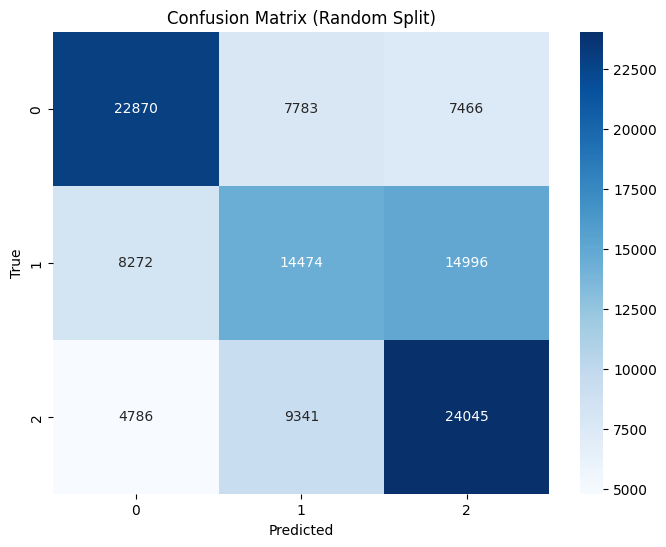

In [9]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Convert cudf DataFrame to pandas DataFrame for confusion matrix
y_test_random_cudf = y_test_random_cudf.to_pandas()
y_pred_random_cudf = y_pred_random_cudf.to_pandas()
conf_matrix_random_cudf = confusion_matrix(y_test_random_cudf, y_pred_random_cudf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_cudf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Split)')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


In [15]:
#SVC in rus tomex and near miss

#convert pandas dataframe to cudf dataframe
X_cudf_rus = cudf.DataFrame.from_pandas(X_rus)
y_cudf_rus = cudf.Series(y_rus)

X_cudf_tomek = cudf.DataFrame.from_pandas(X_tomek)
y_cudf_tomek = cudf.Series(y_tomek)

X_cudf_nm = cudf.DataFrame.from_pandas(X_nm)
y_cudf_nm = cudf.Series(y_nm)

#svm model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovo')
# Random split of the resampled dataset
X_train_random_cudf_rus, X_test_random_cudf_rus, y_train_random_cudf_rus, y_test_random_cudf_rus = cuml_train_test_split(X_cudf_rus, y_cudf_rus, test_size=0.2, random_state=42)
svm_model.fit(X_train_random_cudf_rus, y_train_random_cudf_rus)
y_pred_random_cudf_rus = svm_model.predict(X_test_random_cudf_rus)

# Calculate classification report
print("confusion matrix")
print(confusion_matrix(y_test_random_cudf_rus.to_numpy(), y_pred_random_cudf_rus.to_numpy()))
print("classification report random undersampling")
print(classification_report(y_test_random_cudf_rus.to_numpy(), y_pred_random_cudf_rus.to_numpy()))

X_train_tomek, X_test_tomek, y_train_tomek, y_test_tomek = cuml_train_test_split(X_cudf_tomek, y_cudf_tomek, test_size=0.2, random_state=42)
svm_model.fit(X_train_tomek, y_train_tomek)
y_pred_random_cudf_tomek = svm_model.predict(X_test_tomek)

# Calculate classification report
print("confusion matrix")
print(confusion_matrix(y_test_tomek.to_numpy(), y_pred_random_cudf_tomek.to_numpy()))

print("classification report Tomek links")
print(classification_report(y_test_tomek.to_numpy(), y_pred_random_cudf_tomek.to_numpy()))

X_train_nm, X_test_nm, y_train_nm, y_test_nm = cuml_train_test_split(X_cudf_nm, y_cudf_nm, test_size=0.2, random_state=42)
svm_model.fit(X_train_nm, y_train_nm)
y_pred_random_cudf_nm = svm_model.predict(X_test_nm)
# Calculate classification report
print("confusion matrix")
print(confusion_matrix(y_test_nm.to_numpy(), y_pred_random_cudf_nm.to_numpy()))
print("classification report near misss")
print(classification_report(y_test_nm.to_numpy(), y_pred_random_cudf_nm.to_numpy()))

confusion matrix
[[515 247 160]
 [257 290 375]
 [137 269 527]]
classification report random undersampling
              precision    recall  f1-score   support

         0.0       0.57      0.56      0.56       922
         1.0       0.36      0.31      0.34       922
         2.0       0.50      0.56      0.53       933

    accuracy                           0.48      2777
   macro avg       0.47      0.48      0.48      2777
weighted avg       0.47      0.48      0.48      2777

confusion matrix
[[36104     0    70]
 [  925     0     9]
 [ 5295     0   144]]
classification report Tomek links
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92     36174
         1.0       0.00      0.00      0.00       934
         2.0       0.65      0.03      0.05      5439

    accuracy                           0.85     42547
   macro avg       0.50      0.34      0.32     42547
weighted avg       0.81      0.85      0.79     42547



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

confusion matrix
[[695   0 227]
 [113 604 205]
 [338  17 578]]
classification report near misss
              precision    recall  f1-score   support

         0.0       0.61      0.75      0.67       922
         1.0       0.97      0.66      0.78       922
         2.0       0.57      0.62      0.59       933

    accuracy                           0.68      2777
   macro avg       0.72      0.68      0.68      2777
weighted avg       0.72      0.68      0.68      2777



In [17]:
class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size_1,hidden_seize_2, output_size):
        super(neural_net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_seize_2)
        self.fc3 = nn.Linear(hidden_seize_2, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    




In [18]:
model=neural_net(input_size=20, hidden_size_1=64, hidden_seize_2=32, output_size=3).to(device)
print(model)

neural_net(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


In [24]:
from sklearn.model_selection import KFold
import torch

# Prepare data for PyTorch
X = torch.tensor(X_resampled.values, dtype=torch.float32)
y = torch.tensor(y_resampled.values, dtype=torch.int64)

# K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
num_epochs = 20
input_size = X.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 3
batch_size = 256

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} accuracy: {acc:.4f}")

print(f"Mean cross-validated accuracy over 5 folds: {np.mean(fold_accuracies):.4f}")


  

Fold 1 accuracy: 0.7056
Fold 2 accuracy: 0.7054
Fold 3 accuracy: 0.7177
Fold 4 accuracy: 0.6952
Fold 5 accuracy: 0.7004
Fold 6 accuracy: 0.6948
Fold 7 accuracy: 0.7007
Fold 8 accuracy: 0.7004
Fold 9 accuracy: 0.6886
Fold 10 accuracy: 0.6985
Mean cross-validated accuracy over 5 folds: 0.7007


In [25]:
from sklearn.metrics import classification_report

def run_kfold_nn(X_df, y_series, input_size, hidden_size_1, hidden_size_2, output_size, num_epochs=20, batch_size=256):
    X_tensor = torch.tensor(X_df.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_series.values, dtype=torch.int64)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
        model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        for epoch in range(num_epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                outputs = model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        all_preds = []
        all_true = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_true.extend(yb.cpu().numpy())
        acc = np.mean(np.array(all_preds) == np.array(all_true))
        fold_accuracies.append(acc)
        print(f"Fold {fold+1} accuracy: {acc:.4f}")
        print(f"Classification report for fold {fold+1}:\n{classification_report(all_true, all_preds)}")

    print(f"Mean cross-validated accuracy over 10 folds: {np.mean(fold_accuracies):.4f}")
    return fold_accuracies

# Prepare datasets
datasets = [
    ("RandomUnderSampler", X_rus, y_rus),
    ("TomekLinks", X_tomek, y_tomek),
    ("NearMiss", X_nm, y_nm)
]

for name, X_df, y_series in datasets:
    print(f"\n{name} dataset:")
    run_kfold_nn(
        X_df, y_series,
        input_size=X_df.shape[1],
        hidden_size_1=hidden_size_1,
        hidden_size_2=hidden_size_2,
        output_size=output_size,
        num_epochs=num_epochs,
        batch_size=256
    )



RandomUnderSampler dataset:
Fold 1 accuracy: 0.5133
Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       464
           1       0.44      0.20      0.28       481
           2       0.47      0.73      0.57       444

    accuracy                           0.51      1389
   macro avg       0.51      0.52      0.49      1389
weighted avg       0.51      0.51      0.49      1389

Fold 2 accuracy: 0.4888
Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.55      0.58      0.57       470
           1       0.37      0.28      0.32       452
           2       0.50      0.60      0.55       467

    accuracy                           0.49      1389
   macro avg       0.48      0.49      0.48      1389
weighted avg       0.48      0.49      0.48      1389

Fold 3 accuracy: 0.4917
Classification report for fold 3:
              precision    recall  

/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 accuracy: 0.8539
Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18165
           1       0.00      0.00      0.00       459
           2       0.00      0.00      0.00      2650

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.79     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 accuracy: 0.8490
Classification report for fold 3:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18062
           1       0.00      0.00      0.00       506
           2       0.00      0.00      0.00      2706

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.72      0.85      0.78     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 accuracy: 0.8529
Classification report for fold 4:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18144
           1       0.00      0.00      0.00       453
           2       0.00      0.00      0.00      2677

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.79     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 accuracy: 0.8520
Classification report for fold 5:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18125
           1       0.00      0.00      0.00       452
           2       0.00      0.00      0.00      2697

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.78     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 6 accuracy: 0.8535
Classification report for fold 6:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18157
           1       0.00      0.00      0.00       458
           2       0.00      0.00      0.00      2659

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.79     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 7 accuracy: 0.8539
Classification report for fold 7:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18166
           1       0.00      0.00      0.00       458
           2       0.00      0.00      0.00      2649

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.73      0.85      0.79     21273



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 8 accuracy: 0.8468
Classification report for fold 8:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18013
           1       0.00      0.00      0.00       470
           2       0.00      0.00      0.00      2790

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.72      0.85      0.78     21273



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 9 accuracy: 0.8523
Classification report for fold 9:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18130
           1       0.00      0.00      0.00       480
           2       0.00      0.00      0.00      2663

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.73      0.85      0.78     21273



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 10 accuracy: 0.8494
Classification report for fold 10:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18069
           1       0.00      0.00      0.00       452
           2       0.00      0.00      0.00      2752

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.72      0.85      0.78     21273

Mean cross-validated accuracy over 10 folds: 0.8516

NearMiss dataset:


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 1 accuracy: 0.7019
Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       464
           1       0.92      0.73      0.81       481
           2       0.56      0.72      0.63       444

    accuracy                           0.70      1389
   macro avg       0.72      0.70      0.71      1389
weighted avg       0.73      0.70      0.71      1389

Fold 2 accuracy: 0.6940
Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.65      0.70      0.68       470
           1       0.96      0.70      0.81       452
           2       0.57      0.68      0.62       467

    accuracy                           0.69      1389
   macro avg       0.73      0.69      0.70      1389
weighted avg       0.73      0.69      0.70      1389

Fold 3 accuracy: 0.6926
Classification report for fold 3:
              precision    recall  f1-score   support

         

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Prepare datasets for grid search
undersampled_datasets = [
    ("RandomUnderSampler", X_rus, y_rus),
    ("TomekLinks", X_tomek, y_tomek),
    ("NearMiss", X_nm, y_nm)
]

# Define parameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [50,100]
}

for name, X_df, y_series in undersampled_datasets:
    print(f"\nGridSearchCV for {name} dataset:")
    mlp = MLPClassifier(random_state=42)
    grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_df, y_series)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validated accuracy: {:.4f}".format(grid_search.best_score_))


GridSearchCV for RandomUnderSampler dataset:
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
 

Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'max_iter': 50, 'solver': 'adam'}
Best cross-validated accuracy: 0.4987

GridSearchCV for TomekLinks dataset:
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
 

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 32), 'learning_rate': 'constant', 'max_iter': 50, 'solver': 'adam'}
Best cross-validated accuracy: 0.8588

GridSearchCV for NearMiss dataset:
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
 

Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'max_iter': 50, 'solver': 'adam'}
Best cross-validated accuracy: 0.6869


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
from imblearn.over_sampling import ADASYN

# Separate features and target variable from the original dataset
X = full_dataset.drop(columns=['Diabetes_012'])
y = full_dataset['Diabetes_012']

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# Combine resampled features and target into a new DataFrame
adasyn_dataset = pd.concat([pd.DataFrame(X_adasyn, columns=X.columns), pd.DataFrame(y_adasyn, columns=['Diabetes_012'])], axis=1)

print("Original dataset shape:", y.value_counts())
print("ADASYN resampled dataset shape:", y_adasyn.value_counts())

Original dataset shape: Diabetes_012
0.0    190055
2.0     35097
1.0      4629
Name: count, dtype: int64
ADASYN resampled dataset shape: Diabetes_012
1.0    191592
0.0    190055
2.0    188067
Name: count, dtype: int64


In [28]:
from sklearn.metrics import classification_report

# Prepare ADASYN dataset for PyTorch
X_adasyn_tensor = torch.tensor(X_adasyn.values, dtype=torch.float32)
y_adasyn_tensor = torch.tensor(y_adasyn.values, dtype=torch.int64)

# K-Fold Cross Validation on ADASYN dataset
fold_accuracies_adasyn = []
all_preds = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_adasyn_tensor)):
    model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    X_train, X_val = X_adasyn_tensor[train_idx], X_adasyn_tensor[val_idx]
    y_train, y_val = y_adasyn_tensor[train_idx], y_adasyn_tensor[val_idx]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256)

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    fold_preds = []
    fold_true = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            fold_preds.extend(predicted.cpu().numpy())
            fold_true.extend(yb.cpu().numpy())
    acc = correct / total
    fold_accuracies_adasyn.append(acc)
    all_preds.extend(fold_preds)
    all_true.extend(fold_true)
    print(f"Fold {fold+1} accuracy: {acc:.4f}")

print(f"Mean cross-validated accuracy over 10 folds (ADASYN): {np.mean(fold_accuracies_adasyn):.4f}")
print("Final classification report (ADASYN):")
print(classification_report(all_true, all_preds))

Fold 1 accuracy: 0.6807
Fold 2 accuracy: 0.6967
Fold 3 accuracy: 0.6928
Fold 4 accuracy: 0.7003
Fold 5 accuracy: 0.6970
Fold 6 accuracy: 0.6893
Fold 7 accuracy: 0.6908
Fold 8 accuracy: 0.7043
Fold 9 accuracy: 0.7086
Fold 10 accuracy: 0.7032
Mean cross-validated accuracy over 10 folds (ADASYN): 0.6964
Final classification report (ADASYN):
              precision    recall  f1-score   support

           0       0.76      0.85      0.80    190055
           1       0.69      0.71      0.70    191592
           2       0.62      0.53      0.57    188067

    accuracy                           0.70    569714
   macro avg       0.69      0.70      0.69    569714
weighted avg       0.69      0.70      0.69    569714



In [31]:
import itertools

# Define parameter grid
param_grid = {
    'hidden_size_1': [64, 128],
    'hidden_size_2': [32, 64],
    'lr': [0.001, 0.0005],
    'num_epochs': [10, 20]
}

# Prepare data
X = torch.tensor(X_adasyn.values, dtype=torch.float32)
y = torch.tensor(y_adasyn.values, dtype=torch.int64)

best_acc = 0
best_params = None

for params in itertools.product(*param_grid.values()):
    hidden_size_1, hidden_size_2, lr, num_epochs = params
    fold_accuracies = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=256)

        for epoch in range(num_epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                outputs = model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == yb).sum().item()
                total += yb.size(0)
        acc = correct / total
        fold_accuracies.append(acc)
    mean_acc = np.mean(fold_accuracies)
    print(f"Params: {params}, Mean CV Accuracy: {mean_acc:.4f}")
    if mean_acc > best_acc:
        best_acc = mean_acc
        best_params = params

print(f"Best params: {best_params}, Best mean CV accuracy: {best_acc:.4f}")

Params: (64, 32, 0.001, 10), Mean CV Accuracy: 0.6273
Params: (64, 32, 0.001, 20), Mean CV Accuracy: 0.6607
Params: (64, 32, 0.0005, 10), Mean CV Accuracy: 0.5950
Params: (64, 32, 0.0005, 20), Mean CV Accuracy: 0.6321
Params: (64, 64, 0.001, 10), Mean CV Accuracy: 0.6350
Params: (64, 64, 0.001, 20), Mean CV Accuracy: 0.6661
Params: (64, 64, 0.0005, 10), Mean CV Accuracy: 0.6058
Params: (64, 64, 0.0005, 20), Mean CV Accuracy: 0.6435
Params: (128, 32, 0.001, 10), Mean CV Accuracy: 0.6519
Params: (128, 32, 0.001, 20), Mean CV Accuracy: 0.6859
Params: (128, 32, 0.0005, 10), Mean CV Accuracy: 0.6214
Params: (128, 32, 0.0005, 20), Mean CV Accuracy: 0.6600
Params: (128, 64, 0.001, 10), Mean CV Accuracy: 0.6588
Params: (128, 64, 0.001, 20), Mean CV Accuracy: 0.6921
Params: (128, 64, 0.0005, 10), Mean CV Accuracy: 0.6295
Params: (128, 64, 0.0005, 20), Mean CV Accuracy: 0.6693
Best params: (128, 64, 0.001, 20), Best mean CV accuracy: 0.6921
